In [3]:
import datetime
import numpy as np
import pandas as pd

from itertools import islice, cycle
from more_itertools import pairwise
import scipy.sparse as sp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(14, 8)})

In [4]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 1.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp39-cp39-linux_x86_64.whl size=1039202 sha256=527eaabc7de490bf86eab964cf0fa01330d31e3519cf7892f81e39f5ef63d061
  Stored in directory: /home/filipp_pogorelskiy/.cache/pip/wheels/2d/0a/a4/6aea635157daf166f50276da2f2ceb04d17f5e37cb3f171ac7
Successfully built implicit


<a id="content"></a>
* [Подробное описание данных](#description)
* [EDA](#eda)
    * [Таблица "Users"](#eda_users)
    * [Таблица "Items"](#eda_items)
    * [Таблица "Interactions"](#eda_interactions)
* [Baseline модель](#baseline)
    * [Рекомендация популярного](#rec_pop)
    * [Рекомендация по возрастным группам](#rec_pop_age)
    * [Рекомендация по возрасту и полу](#rec_pop_age_sex)
* [Item-based models](#item_models)
    * [CosineRecommender](#cosine_rec)
    * [TFIDFRecommender](#tfidf_rec)
    * [Подбор гиперпараметра K](#giper_K)
* [CosineRecommender, BM25Recommender и TFIDFRecommender с учетом холодного старта](#cold_start)
* [LightFM](#lightfm)

<a id="description"></a>
# Подробное описание данных

### **_users.csv_**

В данном файле содержится информация о пользователях:
* **_user_id_** - ID пользователя
* **_age_** - возрастная группа пользователя, строка вида "M_N":
    * 18_24 - от 18 до 24 лет включительно
    * 25_34 - от 25 до 34 лет включительно
    * 35_44 - от 35 до 44 лет включительно
    * 45_54 - от 45 до 54 лет включительно
    * 55_64 - от 55 до 64 лет включительно
    * 65_inf - от 65 и старше
* **_income_** - доход пользователя, строка вида "M_N":
    * income_0_20
    * income_20_40
    * income_40_60
    * income_60_90
    * income_90_150
    * income_150_inf
* **_sex_** - пол пользователя:
    * М - мужчина
    * Ж - женщина

* **_kids_flg_** - флаг "наличие ребенка"

### **_items.csv_**

В данном файле содержится информация об объектах (фильмы/сериалы):

* **_item_id_** - ID контента
* **_content_type_** - Тип контента (фильм, сериал)
* **_title_** - Название на русском
* **_title_orig_** - Название оригинальное
* **_genres_** - Жанры из источника (онлайн-кинотеатры)
* **_countries_** - страны
* **_for_kids_** - флаг "контент для детей"
* **_age_rating_** - возрастной рейтинг
* **_studios_** - студии
* **_directors_** - директора
* **_actors_** - актеры
* **_keywords_** - ключевые слова
* **_description_** - описание

### **_interactions.csv_**

В данном файле содержится информация о взаимодействиях пользователей с контентом:

* **_user_id_** - ID пользователя
* **_item_id_** - ID контента
* **_last_watch_dt_** - Дата последнего просмотра
* **_total_dur_** - Общая продолжительность всех просмотров контента

## Данные

In [2]:
users_df = pd.read_csv('users.csv')
items_df = pd.read_csv('items.csv')
interactions_df = pd.read_csv('interactions.csv')

<a id="eda"></a>
# EDA

[Возврат к содержанию](#content)

<a id="eda_users"></a>
### Users

In [3]:
users_df.sample(5)

,user_id,age,income,sex,kids_flg
279355,1043174,age_18_24,income_20_40,М,0
398127,398752,age_25_34,income_20_40,М,1
275017,556402,age_18_24,income_20_40,Ж,0
255543,714581,age_25_34,income_40_60,Ж,1
133174,487376,age_55_64,income_20_40,М,0


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


**Возраст пользователей**

In [5]:
users_df['age'] = users_df['age'].fillna('age_unknown')

In [6]:
users_df['age'] = users_df['age'].astype('category')

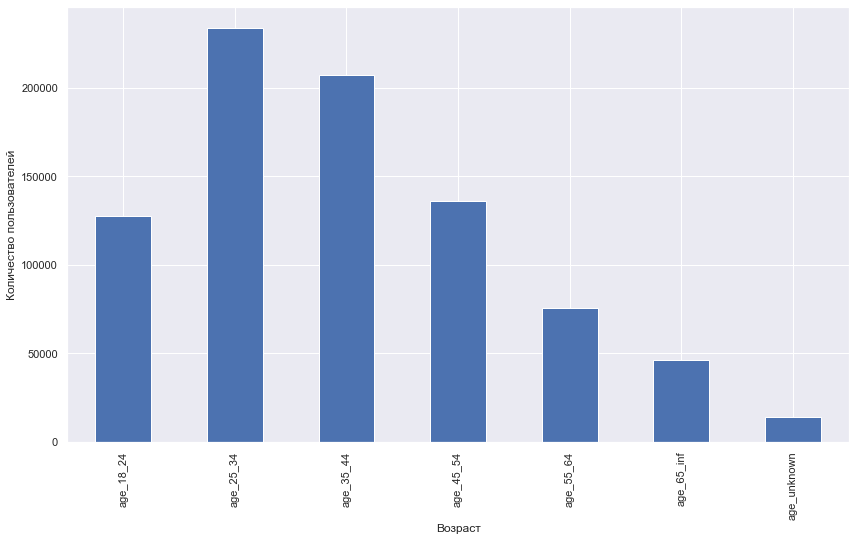

In [7]:
users_df['age'].value_counts().sort_index().plot(kind='bar', 
                                                 ylabel = "Количество пользователей",
                                                 xlabel = "Возраст")
plt.show()

**Доход пользователей**

In [8]:
users_df['income'] = users_df['income'].fillna('income_unknown')

In [9]:
users_df['income'] = users_df['income'].astype('category')

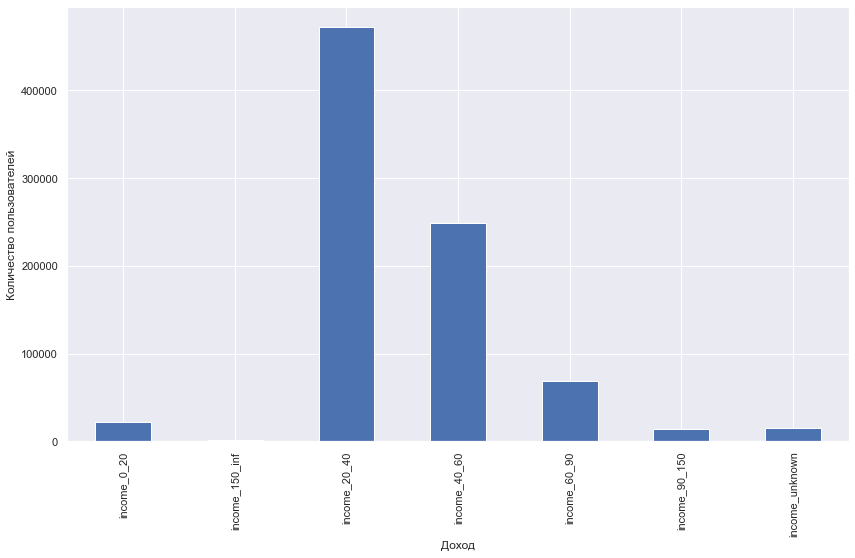

In [10]:
users_df['income'].value_counts().sort_index().plot(kind='bar', 
                                                 ylabel = "Количество пользователей",
                                                 xlabel = "Доход")
plt.show()

**Пол пользователей**

In [11]:
users_df['sex'] = users_df['sex'].fillna('sex_unknown')

In [12]:
users_df['sex'].value_counts()

Ж              425270
М              401096
sex_unknown     13831
Name: sex, dtype: int64

In [13]:
users_df['sex'] = users_df['sex'].map({'Ж':'F',
                                       'М':'M',
                                       'sex_unknown':'sex_unknown'})

In [14]:
users_df['sex'] = users_df['sex'].astype('category')

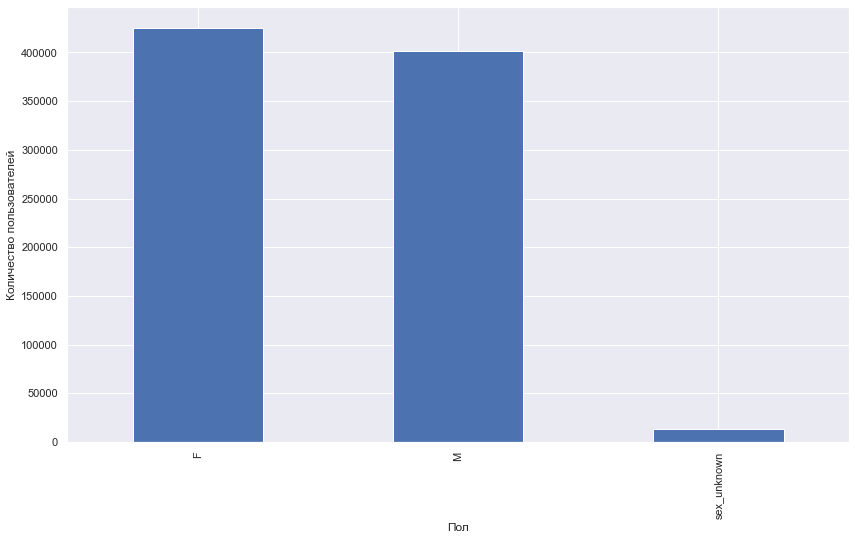

In [15]:
users_df['sex'].value_counts().sort_index().plot(kind='bar', 
                                                 ylabel = "Количество пользователей",
                                                 xlabel = "Пол")
plt.show()

**Наличие ребенка**

In [16]:
users_df['kids_flg'].value_counts()

0    587209
1    252988
Name: kids_flg, dtype: int64

In [17]:
users_df['kids_flg'] = users_df['kids_flg'].astype('bool')

**Итог**

In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   user_id   840197 non-null  int64   
 1   age       840197 non-null  category
 2   income    840197 non-null  category
 3   sex       840197 non-null  category
 4   kids_flg  840197 non-null  bool    
dtypes: bool(1), category(3), int64(1)
memory usage: 9.6 MB


[Возврат к содержанию](#content)

<a id="eda_items"></a>
### Items

In [19]:
items_df.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [20]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [21]:
items_df.nunique()

item_id         15963
content_type        2
title           15293
title_orig      10575
release_year      105
genres           2771
countries         687
for_kids            2
age_rating          6
studios            38
directors        7973
actors          12996
description     15619
keywords        15492
dtype: int64

**title_orig**

In [22]:
len(items_df[items_df['title_orig'].isna()])

4745

In [23]:
items_df[items_df['title_orig'].isna()]['countries'].value_counts().head()

Россия            2899
СССР               918
Украина            240
США                101
Великобритания      87
Name: countries, dtype: int64

In [24]:
items_df['title_orig'] = items_df['title_orig'].fillna('None')

**release_year**

In [25]:
len(items_df[items_df['release_year'].isna()])

98

In [26]:
items_df[items_df['release_year'].isna()][['countries', 'genres']].value_counts().head()

countries         genres                                               
Россия            фитнес                                                   59
                  футбол                                                   22
Великобритания    фитнес                                                    1
Республика Корея  зарубежные, детские песни, развитие, для детей            1
                  зарубежные, для детей, западные мультфильмы, развитие     1
dtype: int64

Заменим пустые значения на 2020

In [27]:
items_df.loc[items_df['release_year'].isna(), 'release_year'] = 2020

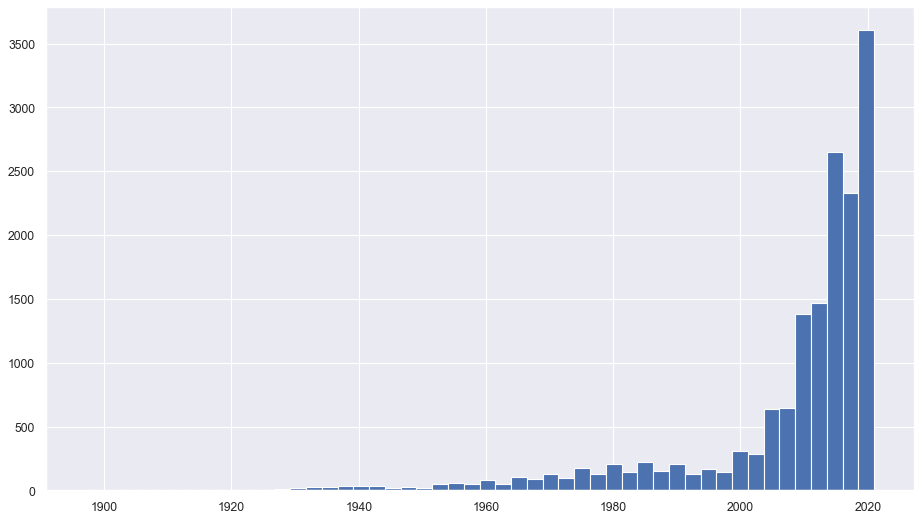

In [28]:
plt.figure(figsize=(14, 8), dpi=80)
items_df['release_year'].hist(bins=50)
plt.show()

Преобразуем год выпуска фильма в интервалы с шагом в 10 лет.

In [29]:
items_df.loc[items_df['release_year'] < 1940, 'release_year_interval'] = 'inf_1940'
items_df.loc[items_df['release_year'] >= 2020, 'release_year_interval'] = '2020_inf'

In [30]:
for year in range(1940, 2020, 10):
    items_df.loc[(items_df['release_year'] >= year) & (items_df['release_year'] < year + 10), 'release_year_interval'] = '{}-{}'.format(year, year + 10)

In [31]:
items_df['release_year_interval'].value_counts()

2010-2020    8788
2020_inf     2276
2000-2010    2168
1980-1990     745
1990-2000     636
1970-1980     553
1960-1970     342
1950-1960     199
inf_1940      139
1940-1950     117
Name: release_year_interval, dtype: int64

In [32]:
items_df = items_df.drop(columns=['release_year'])
items_df['release_year_interval'] = items_df['release_year_interval'].astype('category')

**genres**

In [33]:
items_df['genres'].value_counts()

документальное                                                                  816
драмы                                                                           719
комедии                                                                         564
для взрослых                                                                    482
русские, мелодрамы                                                              416
                                                                               ... 
детские, полнометражные, приключения                                              1
для детей, аниме, полнометражные, приключения, зарубежные, семейное, фэнтези      1
для детей, сериалы, про животных, приключения, комедии                            1
фантастика, фэнтези                                                               1
приключения, мюзиклы, мелодрамы, семейное, комедии                                1
Name: genres, Length: 2771, dtype: int64

In [34]:
items_df['genres'] = items_df['genres'].str.lower()
items_df['genres'] = items_df['genres'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [35]:
items_df['genres'].value_counts()

документальное                                        816
драмы                                                 719
комедии                                               564
для взрослых                                          482
мелодрамы, русские                                    416
                                                     ... 
мелодрамы, спорт, фэнтези                               1
детективы, криминал, триллеры, фэнтези                  1
драмы, комедии, семейное, спорт                         1
мюзиклы, семейное, советские                            1
боевики, драмы, зарубежные, мелодрамы, приключения      1
Name: genres, Length: 2623, dtype: int64

In [36]:
items_df['genres'] = items_df['genres'].astype('category')

**countries**

In [37]:
items_df['countries'].value_counts()

Россия                          4237
США                             4090
СССР                            1401
Франция                         1158
Великобритания                   718
                                ... 
Франция, Польша, Бельгия           1
США, Швеция, ЮАР                   1
США, Аргентина, Мексика            1
США, Германия, Китай, Канада       1
США, Канада, Венгрия               1
Name: countries, Length: 687, dtype: int64

In [38]:
items_df[(items_df['countries'].isna()) & (items_df['title_orig'] != 'None')]#.sample(5)

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_interval
2071,8906,film,Лига чемпионов ФИБА. АЕК(Греция) против Тюрк Т...,BCL. AEK (GRE) - Turk Telecom (TUR),спорт,NaN,NaN,12.0,DAZN,NaN,NaN,"«Тюрк Телеком» уверенно выиграл группу G, одер...","Лига, чемпионов, ФИБА, АЕКГреция, против, Тюрк...",2020_inf
4152,8740,film,Лига чемпионов ФИБА. Тюрк Телеком(Турция) прот...,BCL. Turk Telekom (TUR) vs Hapoel Bank Yahav ...,спорт,NaN,NaN,12.0,DAZN,NaN,NaN,Баскетбольная лига чемпионов берет свое начало...,"Лига, чемпионов, ФИБА, Тюрк, ТелекомТурция, пр...",2020_inf
7186,12295,series,Разговоры животных,Animal Conversations,документальное,NaN,NaN,18.0,NaN,NaN,NaN,"Документальный проект, помогающий лучше понять...","Разговоры, животных, 2021",2020_inf
9505,13864,film,Бруно против Тайсона,Bruno vs. Tyson,спорт,NaN,NaN,18.0,NaN,NaN,NaN,Документальный проект о двух великих боксерах ...,"Бруно, против, Тайсона, 2021",2020_inf
12664,8963,film,Брайан Стивенсон: Борьба за равноправие,True Justice: Bryan Stevenson's Fight for Equa...,документальное,NaN,NaN,16.0,NaN,"Джордж Кунхардт, Питер У. Кунхардт, Тедди Кунх...",Брайан Стивенсон,"Если бы Брайан Стивенсон был супергероем, то о...","Брайан, Стивенсон, Борьба, за, равноправие, 2019",2010-2020
14690,1296,film,Головкин vs Роллс: Перед боем,Fight Feature: Golovkin vs Rolls,"документальное, спорт",NaN,NaN,18.0,DAZN,NaN,NaN,Эксклюзивный контент DAZN только для подписчик...,"Головкин, vs, Роллс, Перед, боем, 2019",2010-2020


In [39]:
items_df.loc[(items_df['countries'].isna()) & (items_df['title_orig'] != 'None'), 'countries'] = 'США'
items_df.loc[(items_df['countries'].isna()) & (items_df['title_orig'] == 'None'), 'countries'] = 'Россия'

In [40]:
items_df['countries'] = items_df['countries'].str.lower()
items_df['countries'] = items_df['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [41]:
items_df['countries'].value_counts()

россия                                                                  4268
сша                                                                     4096
ссср                                                                    1401
франция                                                                 1158
великобритания                                                           718
                                                                        ... 
германия, замбия, сша, юар                                                 1
великобритания, испания, нидерланды                                        1
бельгия, великобритания, германия, дания, исландия, норвегия, швеция       1
австрия, великобритания                                                    1
бельгия, италия, люксембург, франция                                       1
Name: countries, Length: 557, dtype: int64

In [42]:
items_df['countries'] = items_df['countries'].astype('category')

**for_kids**

In [43]:
items_df['for_kids'].value_counts()

0.0    452
1.0    114
Name: for_kids, dtype: int64

In [44]:
items_df.loc[items_df['for_kids'].isna(), 'for_kids'] = 0

In [45]:
items_df['for_kids'] = items_df['for_kids'].astype('bool')

**age_rating**

In [46]:
items_df['age_rating'].value_counts()

16.0    5729
12.0    4147
18.0    2547
6.0     1538
0.0     1518
21.0     482
Name: age_rating, dtype: int64

In [47]:
items_df[items_df['age_rating'].isna()]

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_interval
8297,6316,series,Машины-помощники,None,"для детей, развитие, русские, русские мультфил...",россия,False,NaN,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо...",2010-2020
12352,14409,series,БиБаБу,None,"для детей, развитие, русские, русские мультфил...",россия,False,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан...",2010-2020


In [48]:
items_df.loc[items_df['age_rating'].isna(), 'age_rating'] = 0

In [49]:
items_df['age_rating'] = items_df['age_rating'].astype('category')

**studios**

In [50]:
items_df['studios'].value_counts()

HBO                         353
Ленфильм                    212
Sony Pictures               162
Ленфильм, рентв              46
Paramount                    46
Sky                          30
DAZN                         30
CBS                          27
Starz                        21
BBC                          19
Universal                    18
Showtime                     16
Warner Bros. Television      14
Cinemax                      10
Warner Bros                   9
Fox                           7
Sony Pictures Television      7
Endemol                       4
Fremantle                     4
Amediateka                    3
HBO Max                       2
Мосфильм                      2
CBS All Access                2
Sky, Fremantle                2
Channel 4                     2
Sony Pictures, рентв          2
Disney                        2
HBO, BBC                      2
Sony Plus, рентв              2
Sony Plus                     1
ABC                           1
рентв   

In [51]:
items_df['studios'] = items_df['studios'].fillna('Unknown')

In [52]:
items_df['studios'] = items_df['studios'].astype('category')

**directors**

In [53]:
items_df['directors'].value_counts()

Оливье Шиабоду                511
Денис Франческо                49
Глова Роман Юрьевич            36
Сергей Зарев                   29
Альфред Хичкок                 28
                             ... 
Жюли Грумбах, Элиз МакЛеод      1
Иван Павлов                     1
Джоэл Цвик                      1
Мариана Кальтабиано             1
Яне Магнуссон                   1
Name: directors, Length: 7973, dtype: int64

In [54]:
items_df['directors'] = items_df['directors'].fillna('Unknown')

In [55]:
items_df['directors'] = items_df['directors'].str.lower()
items_df['directors'] = items_df['directors'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [56]:
items_df['directors'] = items_df['directors'].astype('category')

**actors**

In [57]:
items_df['actors'].value_counts().head(10)

Александр Клюквин                                                                                                                                                         25
Тайлер Никсон, Маркус Лондон, Томми Ганн                                                                                                                                  16
Жан-Пьер Морель, Оливье Шиабоду                                                                                                                                            8
Кэти Морган                                                                                                                                                                6
Молли Мэнсон                                                                                                                                                               6
Алина Кукушкина                                                                                                                        

In [58]:
items_df['actors'] = items_df['actors'].fillna('Unknown')

In [59]:
items_df['actors'] = items_df['actors'].str.lower()
items_df['actors'] = items_df['actors'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [60]:
items_df['actors'] = items_df['actors'].astype('category')

**description**

In [61]:
items_df['description'] = items_df['description'].fillna('Unknown')

In [63]:
items_df['keywords'].head(5)

0    Поговори, ней, 2002, Испания, друзья, любовь, ...
1    Голые, перцы, 2014, США, друзья, свадьбы, прео...
2    Тактическая, сила, 2011, Канада, бандиты, ганг...
3    45, лет, 2015, Великобритания, брак, жизнь, лю...
4    Все, решает, мгновение, 1978, СССР, сильные, ж...
Name: keywords, dtype: object

In [64]:
items_df['keywords'] = items_df['keywords'].fillna('Unknown')

In [65]:
items_df['keywords'] = items_df['keywords'].str.lower()
items_df['keywords'] = items_df['keywords'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [66]:
items_df['keywords'] = items_df['keywords'].astype('category')

**Итог**

In [67]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   item_id                15963 non-null  int64   
 1   content_type           15963 non-null  object  
 2   title                  15963 non-null  object  
 3   title_orig             15963 non-null  object  
 4   genres                 15963 non-null  category
 5   countries              15963 non-null  category
 6   for_kids               15963 non-null  bool    
 7   age_rating             15963 non-null  category
 8   studios                15963 non-null  category
 9   directors              15963 non-null  category
 10  actors                 15963 non-null  category
 11  description            15963 non-null  object  
 12  keywords               15963 non-null  category
 13  release_year_interval  15963 non-null  category
dtypes: bool(1), category(8), int64(1), obj

[Возврат к содержанию](#content)

<a id="eda_interactions"></a>
### Interactions

In [68]:
interactions_df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1951104,414616,15297,2021-08-22,22178,75.0
4788468,41116,5987,2021-06-24,49855,100.0
753517,487150,7793,2021-08-02,858,14.0
714762,420571,13463,2021-06-16,23358,100.0
1900798,606557,12360,2021-08-19,10,0.0


In [69]:
interactions_df[interactions_df.watched_pct.isna()]

,user_id,item_id,last_watch_dt,total_dur,watched_pct
18473,296886,617,2021-06-29,1043,NaN
37129,1001166,2228,2021-04-20,215,NaN
42969,54778,9882,2021-08-04,314,NaN
51067,1059297,617,2021-07-13,8501,NaN
56856,571265,617,2021-07-07,2825,NaN
...,...,...,...,...,...
5453471,1003564,1130,2021-04-19,2,NaN
5460370,709070,617,2021-06-23,29,NaN
5461941,13284,13950,2021-04-18,136,NaN
5474507,1049024,174,2021-07-08,7560,NaN


In [70]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


In [71]:
interactions_df.nunique()

user_id          962179
item_id           15706
last_watch_dt       163
total_dur        129788
watched_pct         101
dtype: int64

In [72]:
interactions_df.shape

(5476251, 5)

**last_watch_dt**

Период

In [73]:
interactions_df['last_watch_dt'] = pd.to_datetime(interactions_df['last_watch_dt'])

In [74]:
print('Начальная дата:', interactions_df['last_watch_dt'].min())
print('Конечная дата:', interactions_df['last_watch_dt'].max())

Начальная дата: 2021-03-13 00:00:00
Конечная дата: 2021-08-22 00:00:00


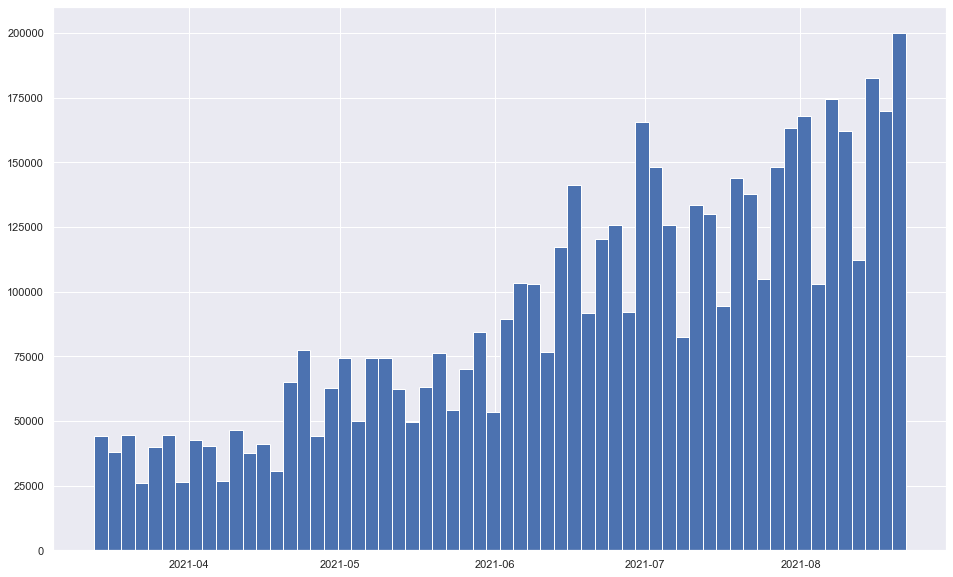

In [75]:
plt.figure(figsize=(16, 10))
interactions_df['last_watch_dt'].hist(bins=60)
plt.show()

In [76]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


### Сохранение данных

In [78]:
users_df.to_csv('users_processed.csv', index=False)
items_df.to_csv('items_processed.csv', index=False)
interactions_df.to_csv('interactions_processed.csv', index=False)

[Возврат к содержанию](#content)

<a id="baseline"></a>
# Baseline

<a id="rec_pop"></a>
### Рекомендация популярного

Бейзлайн моделью будет рекомендация популярного за определенный период.

Далее будем расширять модель, учитывая фичи как пользователей (пол, возраст), так и контента (тип, жанр, год выпуска и т.д.).


In [24]:
users_df = pd.read_csv('users_processed.csv')
items_df = pd.read_csv('items_processed.csv')
interactions_df = pd.read_csv('interactions_processed.csv', parse_dates=['last_watch_dt'])

#### Разобъем на train и test 

In [25]:
test_dates = interactions_df['last_watch_dt'].sort_values().unique()[-7:]
test_dates

array(['2021-08-16T00:00:00.000000000', '2021-08-17T00:00:00.000000000',
       '2021-08-18T00:00:00.000000000', '2021-08-19T00:00:00.000000000',
       '2021-08-20T00:00:00.000000000', '2021-08-21T00:00:00.000000000',
       '2021-08-22T00:00:00.000000000'], dtype='datetime64[ns]')

In [26]:
test_dates = list(pairwise(test_dates))
test_dates

[(numpy.datetime64('2021-08-16T00:00:00.000000000'),
  numpy.datetime64('2021-08-17T00:00:00.000000000')),
 (numpy.datetime64('2021-08-17T00:00:00.000000000'),
  numpy.datetime64('2021-08-18T00:00:00.000000000')),
 (numpy.datetime64('2021-08-18T00:00:00.000000000'),
  numpy.datetime64('2021-08-19T00:00:00.000000000')),
 (numpy.datetime64('2021-08-19T00:00:00.000000000'),
  numpy.datetime64('2021-08-20T00:00:00.000000000')),
 (numpy.datetime64('2021-08-20T00:00:00.000000000'),
  numpy.datetime64('2021-08-21T00:00:00.000000000')),
 (numpy.datetime64('2021-08-21T00:00:00.000000000'),
  numpy.datetime64('2021-08-22T00:00:00.000000000'))]

In [27]:
test_dates[0:2]

[(numpy.datetime64('2021-08-16T00:00:00.000000000'),
  numpy.datetime64('2021-08-17T00:00:00.000000000')),
 (numpy.datetime64('2021-08-17T00:00:00.000000000'),
  numpy.datetime64('2021-08-18T00:00:00.000000000'))]

In [28]:
split_dates = test_dates[0]
train = interactions_df[interactions_df['last_watch_dt'] < split_dates[0]]
test = interactions_df[(interactions_df['last_watch_dt'] >= split_dates[0]) & (interactions_df['last_watch_dt'] < split_dates[1])]
split_dates, train.shape, test.shape

((numpy.datetime64('2021-08-16T00:00:00.000000000'),
  numpy.datetime64('2021-08-17T00:00:00.000000000')),
 (5051815, 5),
 (54546, 5))

In [29]:
from itertools import islice, cycle
class PopularRecommender():
    def __init__(self, max_K=100, days=30, item_column='item_id', dt_column='last_watch_dt'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df, ):
        min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.values
    
    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [30]:
#Разделение на train и test
def train_test_split_dates(data, date_column: str, last_days_num: int = 7, pair_num: int = 0):
    test_dates = data[date_column].sort_values().unique()[-last_days_num:]
    test_dates = list(pairwise(test_dates))
    
    split_dates = test_dates[pair_num]
    train = data[data[date_column] < split_dates[0]]
    test = data[(data[date_column] >= split_dates[0]) & 
                             (data[date_column] < split_dates[1])]
    #print(split_dates)
    return train, test

In [31]:
#функция для вывода метрик
def count_metrics(dates, test_data, pair_num: int = 0):
    precision_list = []
    recall_list = []
    precision_value_list = []
    recall_value_list = []
    print(f'Метрики по test за период : {str(dates[pair_num][0])[:10]} - {str(dates[pair_num][1])[:10]}')
    users_count = test_data.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_data[hit_k] = test_data['rank'] <= k
        precision_list.append(f'Precision@{k}')
        recall_list.append(f'Recall@{k}')
        precision_value_list.append((test_data[hit_k] / k).sum() / users_count)
        recall_value_list.append((test_data[hit_k] / test_data['users_item_count']).sum() / users_count)

    mapN = (test_data["cumulative_rank"] / test_data["users_item_count"]).sum() / users_count
    print(f"MAP@{top_N} = {mapN}")

    mrr = test_data.groupby(level='user_id')['reciprocal_rank'].max().mean()
    print(f"MRR = {mrr}")

    return pd.DataFrame({'Precision' : precision_list,
                               'Precision value' : precision_value_list,
                               'Recall' : recall_list,
                               'Recall value' : recall_value_list}),mapN, mrr

In [32]:
#Функция для получения таблицы с рангами
def create_rank_table(recomendations_table: pd.DataFrame,
                      test: pd.DataFrame,
                      user_id_column: str = 'user_id', 
                      item_id_column: str = 'item_id') -> pd.DataFrame : 
    recomendations_table = recomendations_table.explode(item_id_column)
    recomendations_table['rank'] = recomendations_table.groupby(user_id_column).cumcount() + 1
    test_recs = test.set_index([user_id_column, item_id_column]).join(recomendations_table.set_index([user_id_column, item_id_column]))
    test_recs = test_recs.sort_values(by=[user_id_column, 'rank'])
    test_recs['users_item_count'] = test_recs.groupby(level=user_id_column, sort=False)['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = 1 / test_recs['rank']
    test_recs['reciprocal_rank'] = test_recs['reciprocal_rank'].fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level=user_id_column).cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    return test_recs

In [33]:
train, test = train_test_split_dates(interactions_df, 'last_watch_dt')

In [34]:
train.shape, test.shape

((5051815, 5), (54546, 5))

In [35]:
baseline_model = PopularRecommender(days=7, dt_column='last_watch_dt')
baseline_model.fit(train)

In [36]:
top10_recs = baseline_model.recommend()
top10_recs

array([10440,  9728, 15297, 13865,   341, 12360,  7793, 12192,  4151,
        3734], dtype=int64)

In [37]:
film_titles = pd.Series(items_df['title'].values, index=items_df['item_id']).to_dict()

In [38]:
list(map(film_titles.get, top10_recs))

['Хрустальный',
 'Гнев человеческий',
 'Клиника счастья',
 'Девятаев',
 'Лето - это море',
 'Круэлла',
 'Радиовспышка',
 'Фемида видит',
 'Секреты семейной жизни',
 'Прабабушка легкого поведения']

In [39]:
recomendations = pd.DataFrame({'user_id': test['user_id'].unique()})
top_N = 10
recomendations['item_id'] = baseline_model.recommend(recomendations['user_id'], N=top_N)
recomendations.head()

,user_id,item_id
0,200197,"[10440, 9728, 15297, 13865, 341, 12360, 7793, ..."
1,890735,"[10440, 9728, 15297, 13865, 341, 12360, 7793, ..."
2,701909,"[10440, 9728, 15297, 13865, 341, 12360, 7793, ..."
3,211242,"[10440, 9728, 15297, 13865, 341, 12360, 7793, ..."
4,908470,"[10440, 9728, 15297, 13865, 341, 12360, 7793, ..."


In [40]:
test_recs = create_rank_table(recomendations, test, 'user_id','item_id')

In [41]:
test_recs.tail(5)

last_watch_dt  total_dur  watched_pct  rank  users_item_count  \
user_id item_id                                                                 
1097444 10489      2021-08-16        382          8.0   NaN               1.0   
1097470 3734       2021-08-16       4924         90.0  10.0               4.0   
        6892       2021-08-16       5610        100.0   NaN               4.0   
        1916       2021-08-16        175          3.0   NaN               4.0   
        11973      2021-08-16       8050        100.0   NaN               4.0   

                 reciprocal_rank  cumulative_rank  
user_id item_id                                    
1097444 10489                0.0              NaN  
1097470 3734                 0.1              0.1  
        6892                 0.0              NaN  
        1916                 0.0              NaN  
        11973                0.0              NaN

<a id="baseline_metrics"></a>
**Вычисление метрик**

In [42]:
count_metrics(test_dates, test_recs)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.09470313653539555
MRR = 0.1135042451520248


(      Precision  Precision value     Recall  Recall value
 0   Precision@1         0.051319   Recall@1      0.043155
 1   Precision@2         0.049230   Recall@2      0.078913
 2   Precision@3         0.048271   Recall@3      0.116469
 3   Precision@4         0.043674   Recall@4      0.138005
 4   Precision@5         0.038245   Recall@5      0.149897
 5   Precision@6         0.038472   Recall@6      0.178300
 6   Precision@7         0.035709   Recall@7      0.191992
 7   Precision@8         0.033896   Recall@8      0.207832
 8   Precision@9         0.032408   Recall@9      0.223190
 9  Precision@10         0.031308  Recall@10      0.238152,
 0.09470313653539555,
 0.1135042451520248)

In [50]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
for i in range(0, last_days_num-1):
    train, test = train_test_split_dates(interactions_df, 
                                         'last_watch_dt', 
                                         last_days_num = last_days_num,
                                         pair_num = i)
    baseline_model = PopularRecommender(days = last_days_num, dt_column='last_watch_dt')
    baseline_model.fit(train)
    top10_recs = baseline_model.recommend()
    recomendations = pd.DataFrame({'user_id': test['user_id'].unique()})
    recomendations['item_id'] = baseline_model.recommend(recomendations['user_id'], N=top_N)
    test_recs = create_rank_table(recomendations, test, 'user_id','item_id')
    _, map_10, mrr = count_metrics(test_dates, test_recs, i)
    map_list.append(map_10)
    mrr_list.append(mrr)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.09470313653539555
MRR = 0.1135042451520248
Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.08964241288292825
MRR = 0.10854023935670569
Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.08771484721123946
MRR = 0.10678757639857331
Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.08705037726679514
MRR = 0.1061243619635785
Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.08402966976617872
MRR = 0.10187882950420055
Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.08569115721679142
MRR = 0.10560989439773816


In [55]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.08813860014655477
Средняя MRR за 7 дней = 0.1070741911288035


<a id="rec_pop_age"></a>
### Рекомендации по возрастным группам

In [43]:
merge_table = interactions_df.merge(users_df,left_on = 'user_id',right_on = 'user_id', how='left')

In [44]:
merge_table = merge_table.fillna({'age':'age_unknown',
                                  'income':'income_unknown',
                                  'sex':'sex_unknown',
                                  'kids_flg': False})

Разобъем тренировочные данные по возрасту

In [28]:
train_merge, test_merge = train_test_split_dates(merge_table, 'last_watch_dt')

In [29]:
train_merge.shape, test_merge.shape

((5051815, 9), (54546, 9))

In [30]:
predicted_rec_dict = {}
for age_value in (list(train_merge.age.unique())):
    baseline_model_age = PopularRecommender(days=7, dt_column='last_watch_dt')
    baseline_model_age.fit(train_merge[train_merge.age == age_value])
    top10_recs_age = baseline_model_age.recommend().astype(int)
    predicted_rec_dict[age_value] = top10_recs_age

In [31]:
predicted_rec_dict

{'age_35_44': array([ 9728, 10440, 15297, 13865,  7793,   341, 12192,  3734,  4151,
          512]),
 'age_25_34': array([ 9728, 10440, 15297,  7793,  4151,   341, 13865,  3734, 12360,
        12192]),
 'age_65_inf': array([10440,  9728, 15297,   341, 13865, 12192,   512,  7793, 11863,
        12360]),
 'age_unknown': array([10440, 15297, 12360,  9728,  4151,   341,  2657, 13865, 12192,
         3734]),
 'age_18_24': array([ 9728, 10440, 15297,  7793,  4151,  3734, 13865,  2657,   341,
        12360]),
 'age_45_54': array([ 9728, 10440, 15297, 13865, 12192,   341,   512,  7793, 11863,
         3734]),
 'age_55_64': array([ 9728, 10440, 15297,  7793, 13865, 12192,   512,   341,  4151,
        11863])}

In [32]:
recomendations_age = pd.DataFrame({'age' : predicted_rec_dict.keys(), 'item_id': predicted_rec_dict.values()})
                       #columns=['age', 'item_id'])
#for_subm_rec = recomendations_age.copy()

In [33]:
test_age_unique = test_merge[['user_id','age']].copy().drop_duplicates()
test_age_unique = test_age_unique.merge(recomendations_age,left_on = 'age',right_on = 'age')
recomendations_age = test_age_unique.drop('age', 1)

In [34]:
test_recs_age = create_rank_table(recomendations_age, test_merge, 'user_id', 'item_id')

In [35]:
test_recs_age.tail()

last_watch_dt  total_dur  watched_pct        age  \
user_id item_id                                                    
1097444 10489      2021-08-16        382          8.0  age_18_24   
1097470 3734       2021-08-16       4924         90.0  age_25_34   
        6892       2021-08-16       5610        100.0  age_25_34   
        1916       2021-08-16        175          3.0  age_25_34   
        11973      2021-08-16       8050        100.0  age_25_34   

                       income sex  kids_flg  rank  users_item_count  \
user_id item_id                                                       
1097444 10489    income_20_40   M      True   NaN               1.0   
1097470 3734     income_20_40   M     False   8.0               4.0   
        6892     income_20_40   M     False   NaN               4.0   
        1916     income_20_40   M     False   NaN               4.0   
        11973    income_20_40   M     False   NaN               4.0   

                 reciprocal_rank  cumulative_rank  
user_id item_id                                    
1097444 10489              0.000              NaN  
1097470 3734               0.125            0.125  
        6892               0.000              NaN  
        1916               0.000              NaN  
        11973              0.000              NaN

In [36]:
count_metrics(test_dates, test_recs_age)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.09890330160263164
MRR = 0.11922496593539864


(      Precision  Precision value     Recall  Recall value
 0   Precision@1         0.058124   Recall@1      0.046822
 1   Precision@2         0.052765   Recall@2      0.085465
 2   Precision@3         0.050754   Recall@3      0.123126
 3   Precision@4         0.044973   Recall@4      0.143100
 4   Precision@5         0.041055   Recall@5      0.161864
 5   Precision@6         0.037323   Recall@6      0.175438
 6   Precision@7         0.035321   Recall@7      0.193021
 7   Precision@8         0.033794   Recall@8      0.209623
 8   Precision@9         0.032405   Recall@9      0.224731
 9  Precision@10         0.031232  Recall@10      0.239161,
 0.09890330160263164,
 0.11922496593539864)

In [60]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    
    
    train_merge, test_merge = train_test_split_dates(merge_table, 
                                         'last_watch_dt', 
                                         last_days_num = last_days_num,
                                         pair_num = i)
    for age_value in (list(train_merge.age.unique())):
        baseline_model_age = PopularRecommender(days=7, dt_column='last_watch_dt')
        baseline_model_age.fit(train_merge[train_merge.age == age_value])
        top10_recs_age = baseline_model_age.recommend().astype(int)
        predicted_rec_dict[age_value] = top10_recs_age
    recomendations_age = pd.DataFrame({'age' : predicted_rec_dict.keys(), 'item_id': predicted_rec_dict.values()})
    test_age_unique = test_merge[['user_id','age']].copy().drop_duplicates()
    test_age_unique = test_age_unique.merge(recomendations_age,left_on = 'age',right_on = 'age')
    recomendations_age = test_age_unique.drop('age', 1)
    test_recs_age = create_rank_table(recomendations_age, test_merge, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, test_recs_age, i)
    map_list.append(map_10)
    mrr_list.append(mrr)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.09890330160263164
MRR = 0.11922496593539864
Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.09295707509904282
MRR = 0.11323061831405815
Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.09163857127699225
MRR = 0.11257758427161797
Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.09314998952556236
MRR = 0.11430461906862527
Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.09044494539020614
MRR = 0.11070564228606478
Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.0962547589882354
MRR = 0.11936191744801639


In [61]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.09389144031377844
Средняя MRR за 7 дней = 0.1149008912206302


По сравнению с бейзлайном метрику удалось немного улучшить

<a id="rec_pop_age_sex"></a>
### Рекомендации по возрасту и полу

In [45]:
merge_table['all_features'] = merge_table['age']+ merge_table['sex']

In [24]:
train_all_features, test_all_features = train_test_split_dates(merge_table, 'last_watch_dt')

In [25]:
train_all_features.shape, test_all_features.shape

((5051815, 10), (54546, 10))

In [26]:
predicted_rec_dict_all_feat = {}
for value in (list(train_all_features.all_features.unique())):
    baseline_model_all_features = PopularRecommender(days=7, dt_column='last_watch_dt')
    baseline_model_all_features.fit(train_all_features[train_all_features.all_features == value])
    top10_recs_all_features = baseline_model_all_features.recommend().astype(int)
    predicted_rec_dict_all_feat[value] = top10_recs_all_features

In [27]:
recomendations_age_sex = pd.DataFrame({'age_sex' : predicted_rec_dict_all_feat.keys(), 
                                       'item_id': predicted_rec_dict_all_feat.values()})
#for_subm_rec = recomendations_age_sex.copy()

In [88]:
recomendations_age_sex

,age_sex,item_id
0,age_35_44M,"[9728, 10440, 13865, 15297, 7793, 512, 341, 12..."
1,age_25_34M,"[9728, 10440, 15297, 7793, 13865, 3734, 341, 4..."
2,age_65_infF,"[10440, 15297, 9728, 341, 12192, 13865, 7793, ..."
3,age_25_34F,"[15297, 10440, 9728, 4151, 341, 12360, 3734, 1..."
4,age_unknownsex_unknown,"[10440, 15297, 12360, 9728, 4151, 341, 2657, 1..."
5,age_18_24M,"[9728, 10440, 7793, 13865, 15297, 3734, 4151, ..."
6,age_18_24F,"[9728, 15297, 10440, 4151, 3734, 7793, 2657, 3..."
7,age_45_54M,"[9728, 10440, 15297, 13865, 512, 7793, 12192, ..."
8,age_35_44F,"[15297, 10440, 9728, 341, 12192, 13865, 4151, ..."
9,age_45_54F,"[15297, 10440, 9728, 12192, 341, 13865, 3734, ..."


In [44]:
test_age_sex_unique = test_all_features[['user_id','all_features']].copy().drop_duplicates()
test_age_sex_unique = test_age_sex_unique.merge(recomendations_age_sex,left_on = 'all_features',right_on = 'age_sex')
recomendations_age_sex = test_age_sex_unique.drop('all_features', 1)

In [45]:
test_recs_age_sex = create_rank_table(recomendations_age_sex, test_all_features, 'user_id', 'item_id')

In [46]:
test_recs_age_sex.tail()

last_watch_dt  total_dur  watched_pct        age  \
user_id item_id                                                    
1097444 10489      2021-08-16        382          8.0  age_18_24   
1097470 3734       2021-08-16       4924         90.0  age_25_34   
        6892       2021-08-16       5610        100.0  age_25_34   
        1916       2021-08-16        175          3.0  age_25_34   
        11973      2021-08-16       8050        100.0  age_25_34   

                       income sex  kids_flg all_features     age_sex  rank  \
user_id item_id                                                              
1097444 10489    income_20_40   M      True   age_18_24M         NaN   NaN   
1097470 3734     income_20_40   M     False   age_25_34M  age_25_34M   6.0   
        6892     income_20_40   M     False   age_25_34M         NaN   NaN   
        1916     income_20_40   M     False   age_25_34M         NaN   NaN   
        11973    income_20_40   M     False   age_25_34M         NaN   NaN   

                 users_item_count  reciprocal_rank  cumulative_rank  
user_id item_id                                                      
1097444 10489                 1.0         0.000000              NaN  
1097470 3734                  4.0         0.166667         0.166667  
        6892                  4.0         0.000000              NaN  
        1916                  4.0         0.000000              NaN  
        11973                 4.0         0.000000              NaN

In [47]:
count_metrics(test_dates, test_recs_age_sex)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.10228158616153982
MRR = 0.1222457742041831


(      Precision  Precision value     Recall  Recall value
 0   Precision@1         0.061512   Recall@1      0.051006
 1   Precision@2         0.054517   Recall@2      0.089542
 2   Precision@3         0.051260   Recall@3      0.124446
 3   Precision@4         0.045134   Recall@4      0.143707
 4   Precision@5         0.041359   Recall@5      0.163130
 5   Precision@6         0.038857   Recall@6      0.181702
 6   Precision@7         0.036181   Recall@7      0.197172
 7   Precision@8         0.034035   Recall@8      0.210955
 8   Precision@9         0.032762   Recall@9      0.226714
 9  Precision@10         0.031437  Recall@10      0.240503,
 0.10228158616153982,
 0.1222457742041831)

In [70]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_all_features, test_all_features = train_test_split_dates(merge_table, 
                                                                     'last_watch_dt', 
                                                                     last_days_num = last_days_num,
                                                                     pair_num = i)
    for value in (list(train_all_features.all_features.unique())):
        baseline_model_all_features = PopularRecommender(days=7, dt_column='last_watch_dt')
        baseline_model_all_features.fit(train_all_features[train_all_features.all_features == value])
        top10_recs_all_features = baseline_model_all_features.recommend().astype(int)
        predicted_rec_dict_all_feat[value] = top10_recs_all_features
    recomendations_age_sex = pd.DataFrame({'age_sex' : predicted_rec_dict_all_feat.keys(), 
                                       'item_id': predicted_rec_dict_all_feat.values()})
    test_age_sex_unique = test_all_features[['user_id','all_features']].copy().drop_duplicates()
    test_age_sex_unique = test_age_sex_unique.merge(recomendations_age_sex,left_on = 'all_features',right_on = 'age_sex')
    recomendations_age_sex = test_age_sex_unique.drop('all_features', 1)
    test_recs_age_sex = create_rank_table(recomendations_age_sex, test_all_features, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, test_recs_age_sex, i)
    map_list.append(map_10)
    mrr_list.append(mrr)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.10228158616153982
MRR = 0.1222457742041831
Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.0962995914290215
MRR = 0.11628847178910497
Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.094457701839334
MRR = 0.11531964426304454
Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.09635205302315691
MRR = 0.11712390422276976
Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.09294573654813387
MRR = 0.11285291530032898
Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.09656208330098959
MRR = 0.11961493808793495


In [71]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.09648312538369595
Средняя MRR за 7 дней = 0.11724094131122771


### Объеденим все фичи

In [236]:
merge_table['all_features2'] = merge_table['age']+ merge_table['sex'] + merge_table['watched_pct'].astype('str')

In [237]:
len(merge_table['all_features2'].unique())

42

In [287]:
test_dates

[((numpy.datetime64('2021-08-16T00:00:00.000000000'),
   numpy.datetime64('2021-08-17T00:00:00.000000000')),
  (numpy.datetime64('2021-08-17T00:00:00.000000000'),
   numpy.datetime64('2021-08-18T00:00:00.000000000'))),
 ((numpy.datetime64('2021-08-17T00:00:00.000000000'),
   numpy.datetime64('2021-08-18T00:00:00.000000000')),
  (numpy.datetime64('2021-08-18T00:00:00.000000000'),
   numpy.datetime64('2021-08-19T00:00:00.000000000'))),
 ((numpy.datetime64('2021-08-18T00:00:00.000000000'),
   numpy.datetime64('2021-08-19T00:00:00.000000000')),
  (numpy.datetime64('2021-08-19T00:00:00.000000000'),
   numpy.datetime64('2021-08-20T00:00:00.000000000'))),
 ((numpy.datetime64('2021-08-19T00:00:00.000000000'),
   numpy.datetime64('2021-08-20T00:00:00.000000000')),
  (numpy.datetime64('2021-08-20T00:00:00.000000000'),
   numpy.datetime64('2021-08-21T00:00:00.000000000'))),
 ((numpy.datetime64('2021-08-20T00:00:00.000000000'),
   numpy.datetime64('2021-08-21T00:00:00.000000000')),
  (numpy.dateti

In [297]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_all_features, test_all_features = train_test_split_dates(merge_table, 
                                                                     'last_watch_dt', 
                                                                     last_days_num = last_days_num,
                                                                     pair_num = i)
    for value in (list(train_all_features.all_features2.unique())):
        baseline_model_all_features = PopularRecommender(days=7, dt_column='last_watch_dt')
        baseline_model_all_features.fit(train_all_features[train_all_features.all_features2 == value])
        top10_recs_all_features = baseline_model_all_features.recommend().astype(int)
        predicted_rec_dict_all_feat[value] = top10_recs_all_features
    recomendations_features = pd.DataFrame({'features' : predicted_rec_dict_all_feat.keys(), 
                                       'item_id': predicted_rec_dict_all_feat.values()})
    test_features_unique = test_all_features[['user_id','all_features2']].copy().drop_duplicates()
    test_features_unique = test_features_unique.merge(recomendations_features,left_on = 'all_features2',right_on = 'features')
    recomendations_features = test_features_unique.drop('all_features2', 1)
    test_rec_features = create_rank_table(recomendations_features, test_all_features, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, test_rec_features, i)
    map_list.append(map_10)
    mrr_list.append(mrr)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.15563785511758732
MRR = 0.18141560871335335
Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.14377689214349312
MRR = 0.16876391350770661
Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.14380885761210713
MRR = 0.16892719514201418
Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.14191883759540702
MRR = 0.16754162785779197
Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.13425477765629887
MRR = 0.15605225021784064
Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.13476488016251498
MRR = 0.15910032731113696


In [298]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.1423603500479014
Средняя MRR за 7 дней = 0.16696682045830727


In [ ]:
#########

In [238]:
merge_table['all_features2'] = merge_table['age']+ merge_table['sex'] + merge_table['kids_flg'].astype('str')

In [240]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_all_features, test_all_features = train_test_split_dates(merge_table, 
                                                                     'last_watch_dt', 
                                                                     last_days_num = last_days_num,
                                                                     pair_num = i)
    for value in (list(train_all_features.all_features2.unique())):
        baseline_model_all_features = PopularRecommender(days=7, dt_column='last_watch_dt')
        baseline_model_all_features.fit(train_all_features[train_all_features.all_features2 == value])
        top10_recs_all_features = baseline_model_all_features.recommend().astype(int)
        predicted_rec_dict_all_feat[value] = top10_recs_all_features
    recomendations_features = pd.DataFrame({'features' : predicted_rec_dict_all_feat.keys(), 
                                       'item_id': predicted_rec_dict_all_feat.values()})
    test_features_unique = test_all_features[['user_id','all_features2']].copy().drop_duplicates()
    test_features_unique = test_features_unique.merge(recomendations_features,left_on = 'all_features2',right_on = 'features')
    recomendations_features = test_features_unique.drop('all_features2', 1)
    test_rec_features = create_rank_table(recomendations_features, test_all_features, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, test_rec_features, i)
    map_list.append(map_10)
    mrr_list.append(mrr)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.10190509516426718
MRR = 0.12182376255893362
Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.09597307106007444
MRR = 0.11608519160521547
Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.09435684960991744
MRR = 0.1152387118018441
Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.09636026943859352
MRR = 0.11710672800218616
Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.09267892910084498
MRR = 0.11258720129391298
Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.09643062274566887
MRR = 0.11939464184802086


In [241]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.0962841395198944
Средняя MRR за 7 дней = 0.11703937285168553


[Возврат к содержанию](#content)

<a id="item_models"></a>
## Item-based filtering

In [46]:
users_df = pd.read_csv('users_processed.csv')
items_df = pd.read_csv('items_processed.csv')
interactions_df = pd.read_csv('interactions_processed.csv', parse_dates=['last_watch_dt'])

In [47]:
users_inv_mapping = dict(enumerate(interactions_df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

962179

In [48]:
items_inv_mapping = dict(enumerate(interactions_df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

15706

In [49]:
item_titles = pd.Series(items_df['title'].values, index=items_df['item_id']).to_dict()

In [50]:
class TimeRangeSplit():
    """
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
    """
    def __init__(self, 
                 start_date, 
                 end_date=None, 
                 freq='D', 
                 periods=None, 
                 tz=None, 
                 normalize=False, 
                 closed=None, 
                 train_min_date=None,
                 filter_cold_users=True, 
                 filter_cold_items=True, 
                 filter_already_seen=True):
        
        self.start_date = start_date
        if end_date is None and periods is None:
            raise ValueError("Either 'end_date' or 'periods' must be non-zero, not both at the same time.")

        self.end_date = end_date
        self.freq = freq
        self.periods = periods
        self.tz = tz
        self.normalize = normalize
        self.closed = closed
        self.train_min_date = pd.to_datetime(train_min_date, errors='raise')
        self.filter_cold_users = filter_cold_users
        self.filter_cold_items = filter_cold_items
        self.filter_already_seen = filter_already_seen

        self.date_range = pd.date_range(
            start=start_date, 
            end=end_date, 
            freq=freq, 
            periods=periods, 
            tz=tz, 
            normalize=normalize, 
            closed=closed)

        self.max_n_splits = max(0, len(self.date_range) - 1)
        if self.max_n_splits == 0:
            raise ValueError("Provided parametrs set an empty date range.") 

    def split(self, 
              df, 
              user_column='user_id',
              item_column='item_id',
              datetime_column='date',
              fold_stats=False):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            train_min_mask = df_datetime >= self.train_min_date
        else:
            train_min_mask = df_datetime.notnull()

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        for start, end in pairwise(date_range):
            fold_info = {
                'Start date': start,
                'End date': end
            }
            train_mask = train_min_mask & (df_datetime < start)
            train_idx = df.index[train_mask]
            if fold_stats:
                fold_info['Train'] = len(train_idx)

            test_mask = (df_datetime >= start) & (df_datetime < end)
            test_idx = df.index[test_mask]
            
            if self.filter_cold_users:
                new = np.setdiff1d(
                    df.loc[test_idx, user_column].unique(), 
                    df.loc[train_idx, user_column].unique())
                new_idx = df.index[test_mask & df[user_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New users'] = len(new)
                    fold_info['New users interactions'] = len(new_idx)

            if self.filter_cold_items:
                new = np.setdiff1d(
                    df.loc[test_idx, item_column].unique(), 
                    df.loc[train_idx, item_column].unique())
                new_idx = df.index[test_mask & df[item_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New items'] = len(new)
                    fold_info['New items interactions'] = len(new_idx)

            if self.filter_already_seen:
                user_item = [user_column, item_column]
                train_pairs = df.loc[train_idx, user_item].set_index(user_item).index
                test_pairs = df.loc[test_idx, user_item].set_index(user_item).index
                intersection = train_pairs.intersection(test_pairs)
                test_idx = test_idx[~test_pairs.isin(intersection)]
                # test_mask = rd.df.index.isin(test_idx)
                if fold_stats:
                    fold_info['Known interactions'] = len(intersection)

            if fold_stats:
                fold_info['Test'] = len(test_idx)

            yield (train_idx, test_idx, fold_info)

    def get_n_splits(self, df, datetime_column='date'):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            df_datetime = df_datetime[df_datetime >= self.train_min_date]

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        return max(0, len(date_range) - 1)

In [51]:
last_date = interactions_df['last_watch_dt'].max().normalize()
folds = 7
start_date = last_date - pd.Timedelta(days=folds)
start_date, last_date

(Timestamp('2021-08-15 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [52]:
cv = TimeRangeSplit(start_date=start_date, periods=folds+1)

cv.max_n_splits, cv.get_n_splits(interactions_df, datetime_column='last_watch_dt')

(7, 7)

In [53]:
cv.date_range

DatetimeIndex(['2021-08-15', '2021-08-16', '2021-08-17', '2021-08-18',
               '2021-08-19', '2021-08-20', '2021-08-21', '2021-08-22'],
              dtype='datetime64[ns]', freq='D')

In [54]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


In [55]:
folds_with_stats = list(cv.split(
    interactions_df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='last_watch_dt',
    fold_stats=True
))

folds_info_with_stats = pd.DataFrame([info for _, _, info in folds_with_stats])

In [56]:
folds_info_with_stats

,Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
0,2021-08-15,2021-08-16,4985269,9280,13423,12,17,0,53106
1,2021-08-16,2021-08-17,5051815,7533,10505,12,206,0,43835
2,2021-08-17,2021-08-18,5106361,7118,10105,22,280,0,43926
3,2021-08-18,2021-08-19,5160672,7485,10655,13,21,0,46113
4,2021-08-19,2021-08-20,5217461,7644,10895,19,219,0,47526
5,2021-08-20,2021-08-21,5276101,7918,11155,23,303,0,48687
6,2021-08-21,2021-08-22,5336246,9036,13452,17,97,0,55285


In [57]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [58]:
fold_dates = [(info['Start date'], info['End date']) for _, _, info in folds_with_stats]
fold_dates

[(Timestamp('2021-08-15 00:00:00', freq='D'),
  Timestamp('2021-08-16 00:00:00', freq='D')),
 (Timestamp('2021-08-16 00:00:00', freq='D'),
  Timestamp('2021-08-17 00:00:00', freq='D')),
 (Timestamp('2021-08-17 00:00:00', freq='D'),
  Timestamp('2021-08-18 00:00:00', freq='D')),
 (Timestamp('2021-08-18 00:00:00', freq='D'),
  Timestamp('2021-08-19 00:00:00', freq='D')),
 (Timestamp('2021-08-19 00:00:00', freq='D'),
  Timestamp('2021-08-20 00:00:00', freq='D')),
 (Timestamp('2021-08-20 00:00:00', freq='D'),
  Timestamp('2021-08-21 00:00:00', freq='D')),
 (Timestamp('2021-08-21 00:00:00', freq='D'),
  Timestamp('2021-08-22 00:00:00', freq='D'))]

In [59]:
train_idx, test_idx, info = folds_with_stats[0]

train = interactions_df.loc[train_idx]
test = interactions_df.loc[test_idx]
train.shape, test.shape

((4985269, 5), (53106, 5))

In [60]:
info

{'Start date': Timestamp('2021-08-15 00:00:00', freq='D'),
 'End date': Timestamp('2021-08-16 00:00:00', freq='D'),
 'Train': 4985269,
 'New users': 9280,
 'New users interactions': 13423,
 'New items': 12,
 'New items interactions': 17,
 'Known interactions': 0,
 'Test': 53106}

In [61]:
def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [40]:
train_mat = get_coo_matrix(train, weight_col = 'watched_pct').tocsr()
train_mat

<962178x15706 sparse matrix of type '<class 'numpy.float32'>'
	with 4985269 stored elements in Compressed Sparse Row format>

In [62]:
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender

In [63]:
def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

<a id="cosine_rec"></a>
### CosineRecommender

In [91]:
cosine_model = CosineRecommender(K=10)
cosine_model.fit(train_mat.T) # 

C:\Users\Filipp\anaconda3\lib\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]


In [96]:
mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
mapper

<function __main__.generate_implicit_recs_mapper.<locals>._recs_mapper(user)>

In [97]:
%time
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})
recs['item_id'] = recs['user_id'].map(mapper)
recs.head()

Wall time: 0 ns


,user_id,item_id
0,10010,"[13865, 9728, 15297, 142, 9996, 4151, 2657, 86..."
1,1049777,"[1517, 12580, 6295, 2820, 11188, 13262, 3734, ..."
2,852272,"[15297, 10440, 4151, 3734, 13865, 142, 9728, 9..."
3,812857,"[15297, 13865, 3734, 9728, 142, 9996, 4151, 62..."
4,374989,"[16431, 3737, 4681, 5855, 8275, 141, 9811, 106..."


In [43]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

,user_id,item_id,rank
0,10010,13865,1
0,10010,9728,2
0,10010,15297,3
0,10010,142,4
0,10010,9996,5
0,10010,4151,6
0,10010,2657,7
0,10010,8636,8
0,10010,10772,9
0,10010,7753,10


In [44]:
metrics = compute_metrics2(test, recs, top_N)
metrics

Precision@1     0.044844
Recall@1        0.031769
Precision@2     0.036916
Recall@2        0.051049
Precision@3     0.032242
Recall@3        0.065818
Precision@4     0.028599
Recall@4        0.077342
Precision@5     0.026135
Recall@5        0.088283
Precision@6     0.023979
Recall@6        0.096856
Precision@7     0.022230
Recall@7        0.104517
Precision@8     0.020821
Recall@8        0.111381
Precision@9     0.019693
Recall@9        0.118539
Precision@10    0.018589
Recall@10       0.123954
MAP@10          0.057534
MRR             0.077855
dtype: float64

In [45]:
%%time
validation_results = pd.DataFrame()

for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = interactions_df.loc[train_idx]
    test = interactions_df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    
    cosine_model = CosineRecommender(K=10)
    cosine_model.fit(train_mat.T) # 
    
    mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
    
    recs = pd.DataFrame({
        'user_id': test['user_id'].unique()
    })
    recs['item_id'] = recs['user_id'].map(mapper)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    fold_result = compute_metrics2(test, recs, top_N)
    fold_result.at['Date'] = info['Start date']
    fold_result.at['argv'] = 'K=10'
    fold_result.at['Model'] = 'cosine model'
    
    validation_results = validation_results.append(fold_result, ignore_index=True)

test range - from 2021-08-15 00:00:00 to 2021-08-16 00:00:00
train shape - (4985269, 5), test shape - (53106, 5)



test range - from 2021-08-16 00:00:00 to 2021-08-17 00:00:00
train shape - (5051815, 5), test shape - (43835, 5)



test range - from 2021-08-17 00:00:00 to 2021-08-18 00:00:00
train shape - (5106361, 5), test shape - (43926, 5)



test range - from 2021-08-18 00:00:00 to 2021-08-19 00:00:00
train shape - (5160672, 5), test shape - (46113, 5)



test range - from 2021-08-19 00:00:00 to 2021-08-20 00:00:00
train shape - (5217461, 5), test shape - (47526, 5)



test range - from 2021-08-20 00:00:00 to 2021-08-21 00:00:00
train shape - (5276101, 5), test shape - (48687, 5)



test range - from 2021-08-21 00:00:00 to 2021-08-22 00:00:00
train shape - (5336246, 5), test shape - (55285, 5)



Wall time: 1min 6s


In [46]:
validation_results

,Date,MAP@10,MRR,Model,Precision@1,Precision@10,Precision@2,Precision@3,Precision@4,Precision@5,...,Recall@10,Recall@2,Recall@3,Recall@4,Recall@5,Recall@6,Recall@7,Recall@8,Recall@9,argv
0,2021-08-15,0.074245,0.099394,cosine model,0.054994,0.024497,0.046433,0.040402,0.036916,0.033787,...,0.165906,0.065232,0.083810,0.101796,0.116246,0.127829,0.138213,0.150285,0.159159,K=10
1,2021-08-16,0.080118,0.103494,cosine model,0.058450,0.025041,0.048714,0.041660,0.037363,0.033987,...,0.177243,0.072083,0.091213,0.107507,0.121290,0.135355,0.149163,0.160741,0.169922,K=10
2,2021-08-17,0.077311,0.100741,cosine model,0.056424,0.024322,0.048033,0.040798,0.037143,0.033817,...,0.170680,0.068888,0.087273,0.105120,0.119124,0.132930,0.144018,0.154212,0.164328,K=10
3,2021-08-18,0.076297,0.099500,cosine model,0.054609,0.024607,0.046291,0.039745,0.036563,0.033366,...,0.172431,0.067396,0.085739,0.104353,0.118716,0.132295,0.144946,0.155196,0.165265,K=10
4,2021-08-19,0.074842,0.097909,cosine model,0.055517,0.024044,0.045083,0.038671,0.035351,0.032391,...,0.167772,0.064888,0.082738,0.100650,0.114593,0.128283,0.140546,0.151515,0.160574,K=10
5,2021-08-20,0.074153,0.096608,cosine model,0.052755,0.023985,0.044877,0.038863,0.035661,0.032615,...,0.167678,0.065052,0.083959,0.102193,0.116274,0.129035,0.140930,0.152611,0.161186,K=10
6,2021-08-21,0.073922,0.098405,cosine model,0.054302,0.024272,0.045257,0.039501,0.036080,0.033146,...,0.165945,0.064820,0.083964,0.101654,0.115749,0.127977,0.138412,0.149469,0.158766,K=10


In [47]:
validation_results.agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

,MRR,MAP@10,Recall@10
mean,0.099436,0.075841,0.169665
std,0.002220,0.002263,0.004115
min,0.096608,0.073922,0.165906
max,0.103494,0.080118,0.177243


<a id="tfidf_rec"></a>
### TFIDFRecommender

In [48]:
for model_class in [BM25Recommender, TFIDFRecommender]:
    for train_idx, test_idx, info in folds_with_stats:
        print(f"test range - from {info['Start date']} to {info['End date']}")
        train = interactions_df.loc[train_idx]
        test = interactions_df.loc[test_idx]
        print(f'train shape - {train.shape}, test shape - {test.shape}')
        
        train_mat = get_coo_matrix(train).tocsr()
        
        model = model_class(K=10)
        model.fit(train_mat.T, show_progress=False) 

        mapper = generate_implicit_recs_mapper(model, train_mat, top_N, users_mapping, items_inv_mapping)

        recs = pd.DataFrame({
            'user_id': test['user_id'].unique()
        })
        recs['item_id'] = recs['user_id'].map(mapper)
        recs = recs.explode('item_id')
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        fold_result = compute_metrics2(test, recs, top_N)
        fold_result.at['Date'] = info['Start date']
        fold_result.at['argv'] = 'K=10'
        fold_result.at['Model'] = model.__class__.__name__

        validation_results = validation_results.append(fold_result, ignore_index=True)

test range - from 2021-08-15 00:00:00 to 2021-08-16 00:00:00
train shape - (4985269, 5), test shape - (53106, 5)
test range - from 2021-08-16 00:00:00 to 2021-08-17 00:00:00
train shape - (5051815, 5), test shape - (43835, 5)
test range - from 2021-08-17 00:00:00 to 2021-08-18 00:00:00
train shape - (5106361, 5), test shape - (43926, 5)
test range - from 2021-08-18 00:00:00 to 2021-08-19 00:00:00
train shape - (5160672, 5), test shape - (46113, 5)
test range - from 2021-08-19 00:00:00 to 2021-08-20 00:00:00
train shape - (5217461, 5), test shape - (47526, 5)
test range - from 2021-08-20 00:00:00 to 2021-08-21 00:00:00
train shape - (5276101, 5), test shape - (48687, 5)
test range - from 2021-08-21 00:00:00 to 2021-08-22 00:00:00
train shape - (5336246, 5), test shape - (55285, 5)
test range - from 2021-08-15 00:00:00 to 2021-08-16 00:00:00
train shape - (4985269, 5), test shape - (53106, 5)
test range - from 2021-08-16 00:00:00 to 2021-08-17 00:00:00
train shape - (5051815, 5), test sh

In [49]:
validation_results

,Date,MAP@10,MRR,Model,Precision@1,Precision@10,Precision@2,Precision@3,Precision@4,Precision@5,...,Recall@10,Recall@2,Recall@3,Recall@4,Recall@5,Recall@6,Recall@7,Recall@8,Recall@9,argv
0,2021-08-15,0.074245,0.099394,cosine model,0.054994,0.024497,0.046433,0.040402,0.036916,0.033787,...,0.165906,0.065232,0.083810,0.101796,0.116246,0.127829,0.138213,0.150285,0.159159,K=10
1,2021-08-16,0.080118,0.103494,cosine model,0.058450,0.025041,0.048714,0.041660,0.037363,0.033987,...,0.177243,0.072083,0.091213,0.107507,0.121290,0.135355,0.149163,0.160741,0.169922,K=10
2,2021-08-17,0.077311,0.100741,cosine model,0.056424,0.024322,0.048033,0.040798,0.037143,0.033817,...,0.170680,0.068888,0.087273,0.105120,0.119124,0.132930,0.144018,0.154212,0.164328,K=10
3,2021-08-18,0.076297,0.099500,cosine model,0.054609,0.024607,0.046291,0.039745,0.036563,0.033366,...,0.172431,0.067396,0.085739,0.104353,0.118716,0.132295,0.144946,0.155196,0.165265,K=10
4,2021-08-19,0.074842,0.097909,cosine model,0.055517,0.024044,0.045083,0.038671,0.035351,0.032391,...,0.167772,0.064888,0.082738,0.100650,0.114593,0.128283,0.140546,0.151515,0.160574,K=10
5,2021-08-20,0.074153,0.096608,cosine model,0.052755,0.023985,0.044877,0.038863,0.035661,0.032615,...,0.167678,0.065052,0.083959,0.102193,0.116274,0.129035,0.140930,0.152611,0.161186,K=10
6,2021-08-21,0.073922,0.098405,cosine model,0.054302,0.024272,0.045257,0.039501,0.036080,0.033146,...,0.165945,0.064820,0.083964,0.101654,0.115749,0.127977,0.138412,0.149469,0.158766,K=10
7,2021-08-15,0.025038,0.035391,BM25Recommender,0.019715,0.009433,0.015856,0.014256,0.013116,0.012017,...,0.057767,0.020408,0.027237,0.032693,0.037262,0.041587,0.046905,0.051171,0.054722,K=10
8,2021-08-16,0.027117,0.037275,BM25Recommender,0.020335,0.009863,0.016764,0.014810,0.013447,0.012652,...,0.064119,0.022511,0.029414,0.035394,0.041059,0.046314,0.051580,0.056562,0.060446,K=10
9,2021-08-17,0.025965,0.035772,BM25Recommender,0.019914,0.009424,0.016371,0.014258,0.012810,0.012016,...,0.061183,0.021730,0.028068,0.033272,0.039056,0.043550,0.049272,0.053219,0.057397,K=10


In [50]:
validation_results.groupby(['Model', 'argv']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

MRR                                  MAP@10  \
                           mean       std       min       max      mean   
Model            argv                                                     
BM25Recommender  K=10  0.035454  0.001295  0.033216  0.037275  0.025268   
TFIDFRecommender K=10  0.100490  0.002211  0.097414  0.104374  0.076754   
cosine model     K=10  0.099436  0.002220  0.096608  0.103494  0.075841   

                                                    Recall@10            \
                            std       min       max      mean       std   
Model            argv                                                     
BM25Recommender  K=10  0.001265  0.023187  0.027117  0.059719  0.002760   
TFIDFRecommender K=10  0.002271  0.074749  0.080986  0.171499  0.003451   
cosine model     K=10  0.002263  0.073922  0.080118  0.169665  0.004115   

                                           
                            min       max  
Model            argv                      
BM25Recommender  K=10  0.055278  0.064119  
TFIDFRecommender K=10  0.167739  0.177860  
cosine model     K=10  0.165906  0.177243

[Возврат к содержанию](#content)

<a id="giper_K"></a>
### Подбор гиперпараметра K

### CosineRecommender

In [47]:
%%time
val_results_cosine = pd.DataFrame()

for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = interactions_df.loc[train_idx]
    test = interactions_df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    for k in range(5, 25, 1):
        print(f'K = {k}')
        cosine_model = CosineRecommender(K=k)
        cosine_model.fit(train_mat.T) # 

        mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)

        recs = pd.DataFrame({
            'user_id': test['user_id'].unique()
        })
        recs['item_id'] = recs['user_id'].map(mapper)
        recs = recs.explode('item_id')
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        fold_result = compute_metrics(test, recs, top_N)
        fold_result.at['Date'] = info['Start date']
        fold_result.at['K'] = k
        fold_result.at['Model'] = 'cosine model'

        val_results_cosine = val_results_cosine.append(fold_result, ignore_index=True)

test range - from 2021-08-15 00:00:00 to 2021-08-16 00:00:00
train shape - (4985269, 5), test shape - (53106, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-16 00:00:00 to 2021-08-17 00:00:00
train shape - (5051815, 5), test shape - (43835, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-17 00:00:00 to 2021-08-18 00:00:00
train shape - (5106361, 5), test shape - (43926, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-18 00:00:00 to 2021-08-19 00:00:00
train shape - (5160672, 5), test shape - (46113, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-19 00:00:00 to 2021-08-20 00:00:00
train shape - (5217461, 5), test shape - (47526, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-20 00:00:00 to 2021-08-21 00:00:00
train shape - (5276101, 5), test shape - (48687, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-21 00:00:00 to 2021-08-22 00:00:00
train shape - (5336246, 5), test shape - (55285, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



Wall time: 12min 26s


In [48]:
val_results_cosine.groupby(['K']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

MRR                                  MAP@10                      \
          mean       std       min       max      mean       std       min   
K                                                                            
5.0   0.093405  0.001676  0.091348  0.096131  0.070475  0.001792  0.068497   
6.0   0.095878  0.001663  0.093550  0.098970  0.072581  0.001880  0.070362   
7.0   0.097400  0.001808  0.094940  0.100375  0.074059  0.002025  0.072166   
8.0   0.098162  0.001989  0.095318  0.101231  0.074671  0.002170  0.072789   
9.0   0.098551  0.002063  0.095957  0.101995  0.075032  0.002089  0.073448   
10.0  0.099436  0.002220  0.096608  0.103494  0.075841  0.002263  0.073922   
11.0  0.099954  0.002128  0.097292  0.103773  0.076394  0.002239  0.074248   
12.0  0.100066  0.001974  0.098093  0.104033  0.076462  0.002198  0.074602   
13.0  0.100394  0.002093  0.098340  0.104407  0.076800  0.002261  0.074528   
14.0  0.100514  0.002061  0.098541  0.104457  0.076877  0.002255  0.074462   
15.0  0.100735  0.002093  0.098706  0.104779  0.077008  0.002280  0.074539   
16.0  0.100668  0.002080  0.098644  0.104616  0.076947  0.002260  0.074395   
17.0  0.100676  0.002109  0.098533  0.104609  0.076977  0.002253  0.074443   
18.0  0.100697  0.001935  0.098658  0.104197  0.076987  0.002117  0.074567   
19.0  0.100589  0.001898  0.098448  0.104006  0.076871  0.002121  0.074537   
20.0  0.100618  0.001951  0.098313  0.104147  0.076901  0.002163  0.074536   
21.0  0.100816  0.001823  0.098714  0.104156  0.077047  0.002128  0.074813   
22.0  0.100848  0.001816  0.098893  0.104072  0.077086  0.002128  0.074864   
23.0  0.100818  0.001802  0.098803  0.104046  0.077051  0.002154  0.074678   
24.0  0.100879  0.001678  0.099122  0.104095  0.077102  0.002053  0.074892   

               Recall@10                                
           max      mean       std       min       max  
K                                                       
5.0   0.073890  0.142879  0.003431  0.138847  0.147979  
6.0   0.076241  0.151586  0.003173  0.146844  0.156155  
7.0   0.077545  0.160178  0.003343  0.156060  0.165951  
8.0   0.078288  0.163669  0.004124  0.159412  0.171211  
9.0   0.078873  0.166740  0.003952  0.162345  0.174035  
10.0  0.080118  0.169665  0.004115  0.165906  0.177243  
11.0  0.080499  0.172472  0.004219  0.167406  0.179724  
12.0  0.080715  0.172305  0.003795  0.168798  0.179409  
13.0  0.080926  0.172566  0.004043  0.168268  0.179544  
14.0  0.081041  0.172396  0.003918  0.168381  0.179546  
15.0  0.081220  0.171873  0.004068  0.167002  0.178843  
16.0  0.081052  0.171966  0.004035  0.167455  0.178846  
17.0  0.080967  0.171761  0.004240  0.166804  0.178406  
18.0  0.080761  0.171477  0.004072  0.166711  0.178123  
19.0  0.080683  0.171297  0.003951  0.166802  0.177838  
20.0  0.080837  0.171182  0.004001  0.166432  0.177822  
21.0  0.080878  0.171523  0.003968  0.167096  0.178073  
22.0  0.080778  0.171557  0.003924  0.167164  0.177818  
23.0  0.080838  0.171415  0.004006  0.167026  0.178030  
24.0  0.080770  0.171235  0.003792  0.166815  0.177972

### TFIDFRecommender

In [49]:
%%time
val_results_tfidf = pd.DataFrame()

for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = interactions_df.loc[train_idx]
    test = interactions_df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    for k in range(5, 25, 1):
        print(f'K = {k}')
        tfidf_model = TFIDFRecommender(K=k)
        tfidf_model.fit(train_mat.T) # 

        mapper = generate_implicit_recs_mapper(tfidf_model, train_mat, top_N, users_mapping, items_inv_mapping)

        recs = pd.DataFrame({
            'user_id': test['user_id'].unique()
        })
        recs['item_id'] = recs['user_id'].map(mapper)
        recs = recs.explode('item_id')
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        fold_result = compute_metrics(test, recs, top_N)
        fold_result.at['Date'] = info['Start date']
        fold_result.at['K'] = k
        fold_result.at['Model'] = 'cosine model'

        val_results_tfidf = val_results_tfidf.append(fold_result, ignore_index=True)

test range - from 2021-08-15 00:00:00 to 2021-08-16 00:00:00
train shape - (4985269, 5), test shape - (53106, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-16 00:00:00 to 2021-08-17 00:00:00
train shape - (5051815, 5), test shape - (43835, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-17 00:00:00 to 2021-08-18 00:00:00
train shape - (5106361, 5), test shape - (43926, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-18 00:00:00 to 2021-08-19 00:00:00
train shape - (5160672, 5), test shape - (46113, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-19 00:00:00 to 2021-08-20 00:00:00
train shape - (5217461, 5), test shape - (47526, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-20 00:00:00 to 2021-08-21 00:00:00
train shape - (5276101, 5), test shape - (48687, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



test range - from 2021-08-21 00:00:00 to 2021-08-22 00:00:00
train shape - (5336246, 5), test shape - (55285, 5)
K = 5



K = 6



K = 7



K = 8



K = 9



K = 10



K = 11



K = 12



K = 13



K = 14



K = 15



K = 16



K = 17



K = 18



K = 19



K = 20



K = 21



K = 22



K = 23



K = 24



Wall time: 12min 52s


In [50]:
val_results_tfidf.groupby(['K']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

MRR                                  MAP@10                      \
          mean       std       min       max      mean       std       min   
K                                                                            
5.0   0.094516  0.001855  0.091790  0.097707  0.071559  0.002061  0.069280   
6.0   0.097250  0.002061  0.094652  0.101053  0.073877  0.002223  0.072082   
7.0   0.097961  0.001940  0.095301  0.101380  0.074606  0.002114  0.072916   
8.0   0.098972  0.001991  0.096289  0.102344  0.075422  0.002201  0.073382   
9.0   0.099847  0.002141  0.096877  0.103571  0.076168  0.002230  0.074105   
10.0  0.100490  0.002211  0.097414  0.104374  0.076754  0.002271  0.074749   
11.0  0.101090  0.002098  0.098463  0.104842  0.077293  0.002249  0.075571   
12.0  0.101280  0.001952  0.099208  0.105205  0.077462  0.002221  0.075494   
13.0  0.101420  0.001863  0.099353  0.104833  0.077600  0.002180  0.075423   
14.0  0.101594  0.001874  0.099506  0.105072  0.077741  0.002195  0.075582   
15.0  0.101693  0.001892  0.099768  0.105265  0.077820  0.002189  0.075630   
16.0  0.101763  0.001996  0.099721  0.105511  0.077863  0.002283  0.075424   
17.0  0.101672  0.001958  0.099718  0.105379  0.077808  0.002257  0.075458   
18.0  0.101645  0.001925  0.099611  0.105273  0.077772  0.002252  0.075380   
19.0  0.101703  0.001876  0.099461  0.105111  0.077819  0.002188  0.075574   
20.0  0.101720  0.001828  0.099638  0.105090  0.077825  0.002164  0.075633   
21.0  0.101858  0.001914  0.099614  0.105439  0.077922  0.002196  0.075889   
22.0  0.101823  0.001866  0.099835  0.105310  0.077900  0.002173  0.075735   
23.0  0.101942  0.001883  0.099932  0.105501  0.077999  0.002195  0.075709   
24.0  0.102074  0.001859  0.100142  0.105681  0.078115  0.002197  0.075991   

               Recall@10                                
           max      mean       std       min       max  
K                                                       
5.0   0.075275  0.146184  0.004119  0.139112  0.151107  
6.0   0.078103  0.156057  0.003556  0.152710  0.162824  
7.0   0.078502  0.161214  0.003591  0.157844  0.168146  
8.0   0.079441  0.165210  0.004115  0.161358  0.172965  
9.0   0.080319  0.168605  0.003761  0.165211  0.175761  
10.0  0.080986  0.171499  0.003451  0.167739  0.177860  
11.0  0.081508  0.173866  0.003786  0.170561  0.180873  
12.0  0.081784  0.174031  0.003778  0.170533  0.181214  
13.0  0.081520  0.174429  0.004148  0.170062  0.181843  
14.0  0.081715  0.174122  0.003935  0.170107  0.181206  
15.0  0.081774  0.174186  0.004016  0.170022  0.181442  
16.0  0.081995  0.174097  0.004203  0.169318  0.181384  
17.0  0.081905  0.173836  0.004106  0.169454  0.180976  
18.0  0.081807  0.173529  0.003952  0.169108  0.180458  
19.0  0.081745  0.173470  0.003710  0.169530  0.179924  
20.0  0.081734  0.173466  0.003826  0.169423  0.179871  
21.0  0.081980  0.173465  0.003732  0.169436  0.179836  
22.0  0.081823  0.173339  0.003679  0.169604  0.179669  
23.0  0.081956  0.173545  0.003804  0.169790  0.180113  
24.0  0.082159  0.174010  0.003809  0.170342  0.180926

[Возврат к содержанию](#content)

<a id="cold_start"></a>
## CosineRecommender, BM25Recommender и TFIDFRecommender с учетом холодного старта

Новым пользователям будем рекомендовать популярные фильмы

In [64]:
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender

In [65]:
#Рекомендация популярного по возрасту и полу
def popular_recommend_agesex(train, predict_column: str = 'all_features'):
    rec_dict = {}
    for value in (list(train.all_features.unique())):
            baseline_model_all_features = PopularRecommender(days=7, dt_column='last_watch_dt')
            baseline_model_all_features.fit(train[train[predict_column] == value])
            top10_recs_all_features = baseline_model_all_features.recommend().astype(int)
            rec_dict[value] = top10_recs_all_features
    recomendations_age_sex = pd.DataFrame({'age_sex' : rec_dict.keys(), 
                                           'item_id': rec_dict.values()})
    return recomendations_age_sex

In [66]:
#Рекомендация популярного по возрасту и полу
def rec_cold_users(test_cold, rec_table_merge):
    test_cold = pd.DataFrame({'user_id': test_cold['user_id'].unique()})
    test_cold = test_cold.merge(users_df,left_on = 'user_id',right_on = 'user_id', how = 'left')
    test_cold['all_features'] = test_cold['age'] + test_cold['sex']
    test_cold = test_cold.drop(['age','sex', 'income', 'kids_flg'], 1)
    test_cold.all_features = test_cold.all_features.fillna('age_unknownsex_unknown')
    test_cold = test_cold.merge(rec_table_merge,left_on = 'all_features',right_on = 'age_sex')
    test_cold = test_cold.drop('all_features',1)
    test_cold = test_cold.explode('item_id')
    test_cold['rank'] = test_cold.groupby('user_id').cumcount() + 1
    test_cold = test_cold.groupby('user_id').agg({'item_id': list}).reset_index()
    return test_cold

In [67]:
#функция, которая делит список юзеров на новых и старых
def new_user_split(predict_data, 
                   event_data,
                   data_column_name: str = 'user_id',
                   event_data_column_name: str = 'user_id'
                  ):
    '''
    predict_data - список юзеров для предсказания
    event_data - данные о взаимодействиях юзеров с фильмами
    Функция возвращает два DataFrame:
    1 - список юзеров, которые встречались нам ранее
    2 - список новых юзеров, про которых ничего неизвестно
    '''
    current_users = predict_data[data_column_name].copy()
    current_users = pd.DataFrame(list(set(current_users) & set(event_data[event_data_column_name])), columns = [data_column_name])
    new_users = predict_data[data_column_name].copy()
    new_users = pd.DataFrame(list(set(new_users) - set(event_data[event_data_column_name])), columns = [data_column_name])
    return current_users, new_users

### CosineRecommender

In [115]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_cosine, test_cosine = train_test_split_dates(merge_table, 
                                                       'last_watch_dt',
                                                       last_days_num = last_days_num,
                                                       pair_num = i)
    test_cosine_old, test_cosine_cold = new_user_split(predict_data = test_cosine, event_data= train_cosine)
    cold_recomendations = popular_recommend_agesex(train_cosine, predict_column = 'all_features')
    test_cosine_cold = rec_cold_users(test_cosine_cold, cold_recomendations)
    train_mat = get_coo_matrix(train_cosine, weight_col = 'watched_pct').tocsr()
    cosine_model = CosineRecommender(K=10)
    cosine_model.fit(train_mat.T)
    mapper_cosine = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
    cosine_rec_not_cold = pd.DataFrame({'user_id': test_cosine_old['user_id'].unique()})
    cosine_rec_not_cold['item_id'] = cosine_rec_not_cold['user_id'].map(mapper_cosine)
    cosine_recommend = pd.concat([cosine_rec_not_cold, test_cosine_cold], ignore_index=True)
    cosine_rank_table = create_rank_table(cosine_recommend, test_cosine, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, cosine_rank_table, i)
    map_list.append(map_10)
    mrr_list.append(mrr)
    print(f"MAP@{top_N} = {map_10}")
    print(f"MRR = {mrr}")
    
    

C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.0956383766707315
MRR = 0.11524195720679177
MAP@10 = 0.0956383766707315
MRR = 0.11524195720679177


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.09073518162006836
MRR = 0.11136113081422655
MAP@10 = 0.09073518162006836
MRR = 0.11136113081422655


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.08904031559397516
MRR = 0.11020394935053109
MAP@10 = 0.08904031559397516
MRR = 0.11020394935053109


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.08828992730194746
MRR = 0.10915832799448393
MAP@10 = 0.08828992730194746
MRR = 0.10915832799448393


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.086571928766487
MRR = 0.10657433750291612
MAP@10 = 0.086571928766487
MRR = 0.10657433750291612


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.08563138230159964
MRR = 0.107816701072938
MAP@10 = 0.08563138230159964
MRR = 0.107816701072938


In [116]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.08931785204246818
Средняя MRR за 7 дней = 0.11005940065698123


In [71]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_cosine, test_cosine = train_test_split_dates(merge_table, 
                                                       'last_watch_dt',
                                                       last_days_num = last_days_num,
                                                       pair_num = i)
    test_cosine_old, test_cosine_cold = new_user_split(predict_data = test_cosine, event_data= train_cosine)
    cold_recomendations = popular_recommend_agesex(train_cosine, predict_column = 'all_features')
    test_cosine_cold = rec_cold_users(test_cosine_cold, cold_recomendations)
    train_mat_cos = get_coo_matrix(train_cosine).tocsr()
    cosine_model = CosineRecommender(K=15)
    cosine_model.fit(train_mat_cos.T)
    mapper_cosine = generate_implicit_recs_mapper(cosine_model, train_mat_cos, top_N, users_mapping, items_inv_mapping)
    cosine_rec_not_cold = pd.DataFrame({'user_id': test_cosine_old['user_id'].unique()})
    cosine_rec_not_cold['item_id'] = cosine_rec_not_cold['user_id'].map(mapper_cosine)
    cosine_recommend = pd.concat([cosine_rec_not_cold, test_cosine_cold], ignore_index=True)
    cosine_rank_table = create_rank_table(cosine_recommend, test_cosine, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, cosine_rank_table, i)
    map_list.append(map_10)
    mrr_list.append(mrr)


Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.11143112452775086
MRR = 0.13548757470684072



Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.10548299025570174
MRR = 0.12997756642981023



Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.10477584463707648
MRR = 0.12968613291669037



Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.10271673309229337
MRR = 0.12731758634934714



Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.10243195498985797
MRR = 0.12654613686366095



Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.10150699277439333
MRR = 0.12809434430105282


In [72]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.1047242733795123
Средняя MRR за 7 дней = 0.12951822359456705


### TFIDFRecommender

In [117]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_tfidf, test_tfidf = train_test_split_dates(merge_table, 
                                                       'last_watch_dt',
                                                       last_days_num = last_days_num,
                                                       pair_num = i)
    test_tfidf_old, test_tfidf_cold = new_user_split(predict_data = test_tfidf, event_data= train_tfidf)
    cold_recomendations = popular_recommend_agesex(train_tfidf, predict_column = 'all_features')
    test_tfidf_cold = rec_cold_users(test_tfidf_cold, cold_recomendations)
    train_mat_tfidf = get_coo_matrix(train_tfidf, weight_col = 'watched_pct').tocsr()
    tfidf_model = TFIDFRecommender(K=10)
    tfidf_model.fit(train_mat_tfidf.T)
    mapper_tfidf = generate_implicit_recs_mapper(tfidf_model, train_mat_tfidf, top_N, users_mapping, items_inv_mapping)
    tfidf_rec_not_cold = pd.DataFrame({'user_id': test_tfidf_old['user_id'].unique()})
    tfidf_rec_not_cold['item_id'] = tfidf_rec_not_cold['user_id'].map(mapper_tfidf)
    tfidf_recommend = pd.concat([tfidf_rec_not_cold, test_tfidf_cold], ignore_index=True)
    tfidf_rank_table = create_rank_table(tfidf_recommend, test_tfidf, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, tfidf_rank_table, i)
    map_list.append(map_10)
    mrr_list.append(mrr)

C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.09994331451332683
MRR = 0.12124932369185802


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.09561485425946657
MRR = 0.11754111188990947


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.09365576775242976
MRR = 0.1165428457601428


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.09228091070223057
MRR = 0.11440718408007346


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.09045038565348254
MRR = 0.11164507819710687


C:\Users\pogorelskiy\AppData\Roaming\Python\Python36\site-packages\implicit\nearest_neighbours.py:184: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data ** 2))[X.row]



Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.08956021697069765
MRR = 0.1127067932202354


In [118]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.09358424164193897
Средняя MRR за 7 дней = 0.11568205613988765


In [73]:
last_days_num = 7
top_N = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for i in range(0, last_days_num-1):
    train_tfidf, test_tfidf = train_test_split_dates(merge_table, 
                                                       'last_watch_dt',
                                                       last_days_num = last_days_num,
                                                       pair_num = i)
    test_tfidf_old, test_tfidf_cold = new_user_split(predict_data = test_tfidf, event_data= train_tfidf)
    cold_recomendations = popular_recommend_agesex(train_tfidf, predict_column = 'all_features')
    test_tfidf_cold = rec_cold_users(test_tfidf_cold, cold_recomendations)
    train_mat_tfidf = get_coo_matrix(train_tfidf).tocsr()
    tfidf_model = TFIDFRecommender(K=17)
    tfidf_model.fit(train_mat_tfidf.T)
    mapper_tfidf = generate_implicit_recs_mapper(tfidf_model, train_mat_tfidf, top_N, users_mapping, items_inv_mapping)
    tfidf_rec_not_cold = pd.DataFrame({'user_id': test_tfidf_old['user_id'].unique()})
    tfidf_rec_not_cold['item_id'] = tfidf_rec_not_cold['user_id'].map(mapper_tfidf)
    tfidf_recommend = pd.concat([tfidf_rec_not_cold, test_tfidf_cold], ignore_index=True)
    tfidf_rank_table = create_rank_table(tfidf_recommend, test_tfidf, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, tfidf_rank_table, i)
    map_list.append(map_10)
    mrr_list.append(mrr)


Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.11195682144463626
MRR = 0.1359540708534493



Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.10592861544170094
MRR = 0.13047656821638107



Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.10574015940539055
MRR = 0.1306829900225082



Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.10332892520199531
MRR = 0.12809052721588612



Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.10300580941276828
MRR = 0.12734230557153092



Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.10222688880115191
MRR = 0.1288307346027133


In [74]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.10536453661794055
Средняя MRR за 7 дней = 0.13022953274707813


[Возврат к содержанию](#content)

<a id="lightfm"></a>
### LightFM

In [90]:
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
import typing as tp

In [91]:
def get_n_recommendations_for_user(user_id: str,
                                    model: LightFM,
                                    train_matrix: sp.coo_matrix,
                                    user_to_id: tp.Dict[str, int],
                                    id_to_item: tp.Dict[int, str],
                                    n_recommendations: int
                                ) -> pd.DataFrame:
    user_inner_id = user_to_id[user_id]
    scores = model.predict(user_ids=user_inner_id,
                            item_ids=np.arange(train_matrix.shape[1]),
                            num_threads=20)
    user_watched_items = train_matrix.col[train_matrix.row == user_inner_id]
    scores[user_watched_items] = -np.inf

    recommended_item_inner_ids = np.argpartition(scores, -np.arange(n_recommendations))[-n_recommendations:][::-1]
    recommended_item_ids = [id_to_item[x] for x in recommended_item_inner_ids]
    return recommended_item_ids

In [96]:
%%time
last_days_num = 7
n_recommendations = 10
map_list = list()
mrr_list = list()
predicted_rec_dict = {}
for days in range(0, last_days_num-1):
    train, test = train_test_split_dates(interactions_df,
                                         'last_watch_dt',
                                         last_days_num = last_days_num,
                                         pair_num = days)
    test = test.loc[test["user_id"].isin(train["user_id"]) & test["item_id"].isin(train["item_id"])]
    train = pd.merge(train, items_df[["item_id", "title", "genres"]], on="item_id")
    test = pd.merge(test, items_df[["item_id", "title", "genres"]], on="item_id")
    lfm_dataset = LFMDataset()
    lfm_dataset.fit(users=train["user_id"].values,
                    items=train["item_id"].values)
    train_matrix, _ = lfm_dataset.build_interactions(zip(*train[["user_id", "item_id"]].values.T))
    lfm_model = LightFM(learning_rate=0.05, 
                        loss='warp', 
                        no_components=64,
                        max_sampled=5,
                        random_state=137)
    lfm_model.fit(interactions=train_matrix, 
                  epochs=15,
                  num_threads=4);
    id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}
    user_id = test['user_id'].unique()
    user_id = test['user_id'].unique()
    rec_df = pd.DataFrame()
    for i in user_id:
        recommended_items = get_n_recommendations_for_user(user_id=i,
                                                           model=lfm_model,
                                                           train_matrix=train_matrix,
                                                           user_to_id=lfm_dataset._user_id_mapping,
                                                           id_to_item=id_item_mapping,
                                                           n_recommendations=n_recommendations)
        rec_df = rec_df.append(pd.DataFrame({"user_id": i, 
                                             "item_id": recommended_items}).merge(items_df[["item_id", 
                                                                                            "title", "genres"]]))
    test_rec_df = rec_df.drop(['title','genres'], 1)
    test_rec_df = create_rank_table(test_rec_df, test, 'user_id', 'item_id')
    _, map_10, mrr = count_metrics(test_dates, test_rec_df, days)
    map_list.append(map_10)
    mrr_list.append(mrr)

Метрики по test за период : 2021-08-16 - 2021-08-17
MAP@10 = 0.07901718467945391
MRR = 0.10201278062971805
Метрики по test за период : 2021-08-17 - 2021-08-18
MAP@10 = 0.076469352609904
MRR = 0.09902725612589494
Метрики по test за период : 2021-08-18 - 2021-08-19
MAP@10 = 0.07498285927403567
MRR = 0.0980312431652353
Метрики по test за период : 2021-08-19 - 2021-08-20
MAP@10 = 0.07379488612099493
MRR = 0.09671879366415373
Метрики по test за период : 2021-08-20 - 2021-08-21
MAP@10 = 0.07323546607832444
MRR = 0.09579333348392105
Метрики по test за период : 2021-08-21 - 2021-08-22
MAP@10 = 0.07537214605763148
MRR = 0.10051067551067577
Wall time: 1h 3min 31s


In [97]:
print(f"Средняя MAP@{top_N} за {last_days_num} дней = {np.mean(map_list)}")
print(f"Средняя MRR за {last_days_num} дней = {np.mean(mrr_list)}")

Средняя MAP@10 за 7 дней = 0.07547864913672407
Средняя MRR за 7 дней = 0.0986823470965998


[Возврат к содержанию](#content)